<a href="https://colab.research.google.com/github/kasmikota-rushi/DV_LAB-TASKS/blob/main/dv_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text(0.5, 1.0, 'Accident locations (color+size ~ severity)')

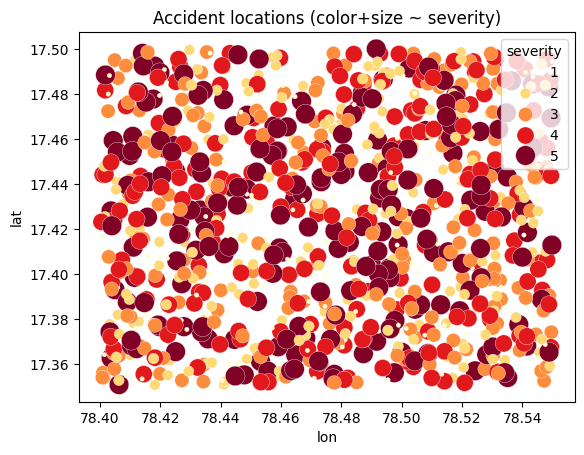

In [ ]:
import pandas as pd

df = pd.read_csv('/content/Traffic_Accident_Analysis_Dataset.csv')

import seaborn as sns
import matplotlib.pyplot as plt

# severity: 0-5 numeric
sns.scatterplot(x='lon', y='lat', hue='severity', palette='YlOrRd', size='severity', sizes=(10,200), data=df)
plt.title('Accident locations (color+size ~ severity)')

In [ ]:
import folium
from sklearn.cluster import DBSCAN
import numpy as np

# Coordinates for clustering
coords = df[['lat', 'lon']].to_numpy()

# Spatial clustering (roughly 0.5 km radius)
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Assign cluster labels
df['cluster'] = db.labels_

# Create map centered on mean coordinates
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=12)

# Add clustered points with color by severity
for _, row in df.iterrows():
    color = 'red' if row['severity'] >= 4 else 'orange' if row['severity'] == 3 else 'yellow'
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3 + row['severity'],
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"Cluster: {row['cluster']}, Severity: {row['severity']}, Cause: {row['cause']}"
    ).add_to(m)

m.save("high_risk_zones.html")


Text(0, 0.5, 'Count')

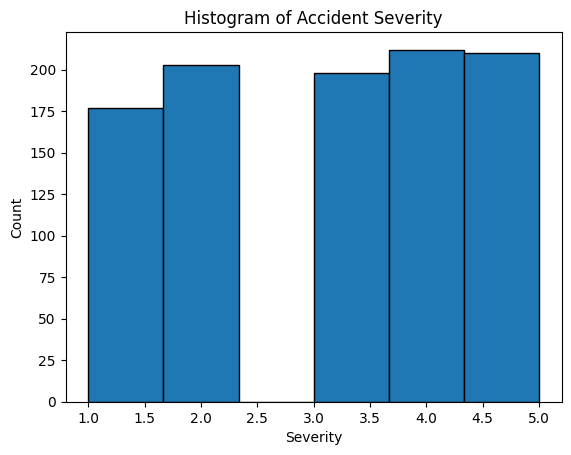

In [ ]:
plt.hist(df['severity'], bins=6, edgecolor='black')
plt.title('Histogram of Accident Severity')
plt.xlabel('Severity')
plt.ylabel('Count')


Text(0.5, 1.0, 'Vehicle Types Involved in Accidents')

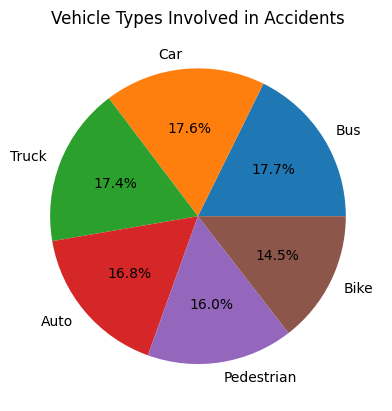

In [ ]:
plt.pie(df['vehicle_type'].value_counts(), labels=df['vehicle_type'].value_counts().index, autopct='%1.1f%%')
plt.title('Vehicle Types Involved in Accidents')


Text(0, 0.5, 'Severity')

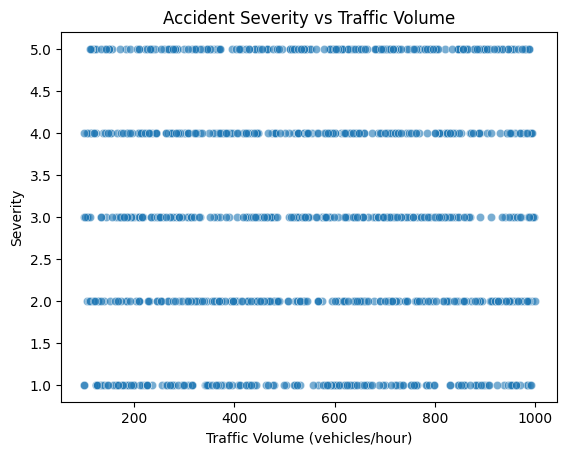

In [ ]:
sns.scatterplot(x='traffic_volume', y='severity', data=df, alpha=0.6)
plt.title('Accident Severity vs Traffic Volume')
plt.xlabel('Traffic Volume (vehicles/hour)')
plt.ylabel('Severity')



([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Distracted'),
  Text(1, 0, 'Speeding'),
  Text(2, 0, 'Bad Weather'),
  Text(3, 0, 'Mechanical Failure'),
  Text(4, 0, 'Drunk Driving'),
  Text(5, 0, 'Signal Jump')])

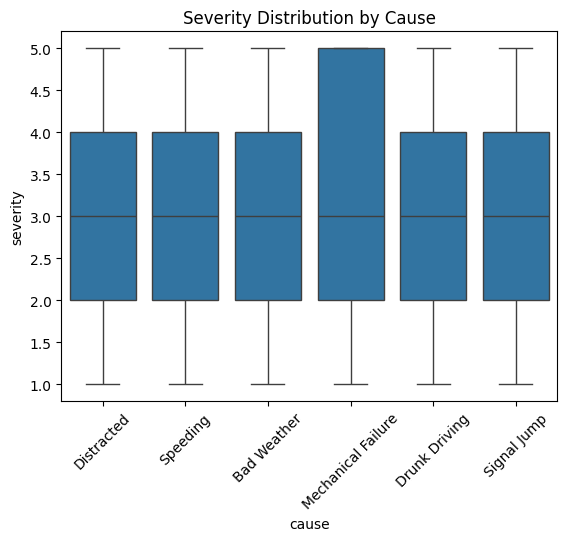

In [ ]:
sns.boxplot(x='cause', y='severity', data=df)
plt.title('Severity Distribution by Cause')
plt.xticks(rotation=45)


Text(0.5, 1.02, 'Pair Plot: Severity, Speed, Traffic Density')

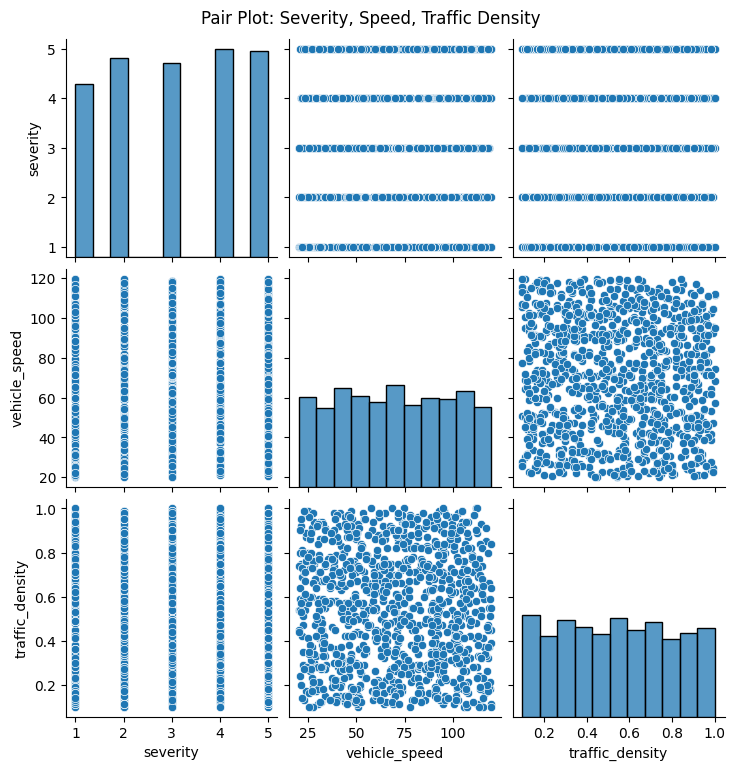

In [ ]:
sns.pairplot(df[['severity','vehicle_speed','traffic_density']])
plt.suptitle('Pair Plot: Severity, Speed, Traffic Density', y=1.02)


In [ ]:
# Code sketch (plotly treemap):
import plotly.express as px
agg = df.groupby(['zone','intersection']).agg(count=('severity','size')).reset_index()
fig = px.treemap(agg, path=['zone','intersection'], values='count', color='count')
fig.show()

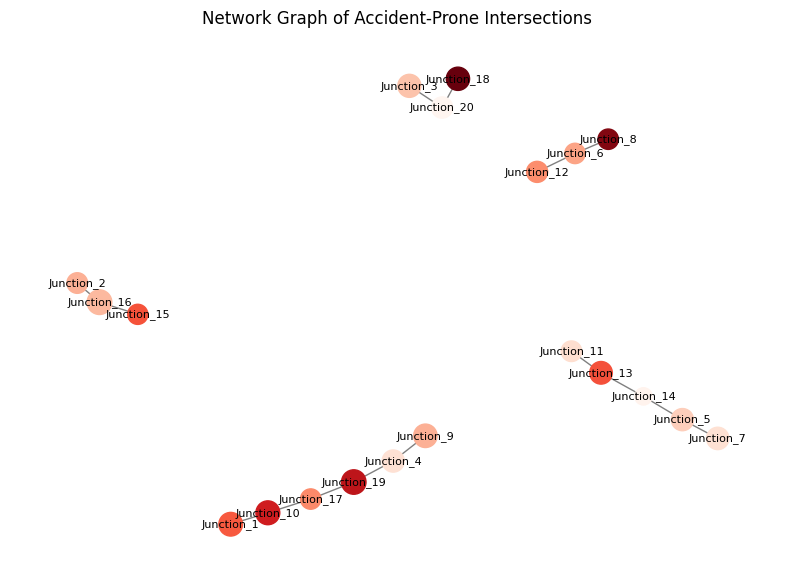

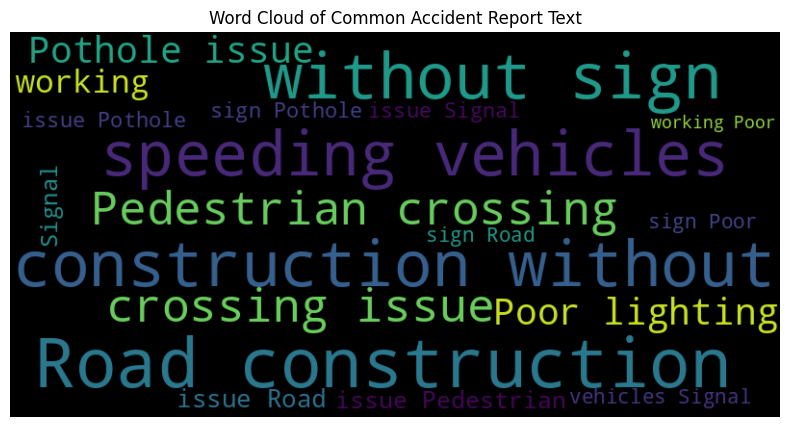

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'df_reports' is already defined and contains 'report_text'
# If not, you might need to create df_reports from your main DataFrame (df)
# Example: df_reports = df[['report_text']].copy()

# TF-IDF Vectorization
# Using a placeholder DataFrame 'df_reports' based on the provided code
# Make sure to adjust this based on your actual DataFrame containing 'report_text'
# For demonstration, let's assume 'df' contains 'report_text'
# Create a temporary DataFrame with 'report_text'
df_reports = df[['report_text']].copy()


vec = TfidfVectorizer(stop_words='english', max_features=2000)
X_text = vec.fit_transform(df_reports['report_text'].dropna()) # Handle potential NaN values

# Word cloud of common complaints
text = " ".join(df_reports['report_text'].dropna())
wc = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5)) # Add figure size for better visualization
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Accident Report Text') # Add a title
plt.show()

In [ ]:
import folium

# Calculate the mean latitude and longitude to center the map
city_lat = df['lat'].mean()
city_lon = df['lon'].mean()

# Define a function to determine marker color based on severity
def severity_color(severity):
    if severity >= 4:
        return 'red'
    elif severity == 3:
        return 'orange'
    else:
        return 'yellow'

# Create a Folium map centered on the mean coordinates
m = folium.Map(location=[city_lat, city_lon], zoom_start=12)

# Add circle markers for each accident location
for _, r in df.iterrows():
    folium.CircleMarker(
        location=[r.lat, r.lon],
        radius=3 + r.severity,  # Size based on severity
        color=severity_color(r.severity), # Color based on severity
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Display the map
m

In [ ]:
import folium
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


# --- Re-run DBSCAN Clustering ---
# Coordinates for clustering
coords = df[['lat', 'lon']].to_numpy()

# Spatial clustering (roughly 0.5 km radius)
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Assign cluster labels
df['cluster'] = db.labels_
# --- End of DBSCAN Clustering ---


# --- Generate Line Data for Accident-Prone Routes ---
# Create a graph
G = nx.Graph()

# Add nodes with positions and cluster information
for idx, row in df.iterrows():
    G.add_node(idx, pos=(row.lon, row.lat), cluster=row['cluster'])

# Add edges between nodes in the same cluster
for cluster_id in df['cluster'].unique():
    if cluster_id != -1: # Exclude noise points
        cluster_nodes = df[df['cluster'] == cluster_id].index.tolist()
        # Add edges between all pairs of nodes within the cluster
        for i in range(len(cluster_nodes)):
            for j in range(i + 1, len(cluster_nodes)):
                G.add_edge(cluster_nodes[i], cluster_nodes[j])

# Get positions for plotting
pos = nx.get_node_attributes(G, 'pos')

# Create a Folium map
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=12)

# Add edges to the map
for u, v in G.edges():
    p1 = pos[u]
    p2 = pos[v]
    folium.PolyLine([p1[::-1], p2[::-1]], color='blue', weight=1.5, opacity=0.7).add_to(m)

# Add nodes (accident locations) to the map
for idx, row in df.iterrows():
    color = 'red' if row['severity'] >= 4 else 'orange' if row['severity'] == 3 else 'yellow'
    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=3 + row.severity,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"Cluster: {row['cluster']}, Severity: {row['severity']}, Cause: {row['cause']}"
    ).add_to(m)

# Display the map
m
# --- End of Line Data Generation ---

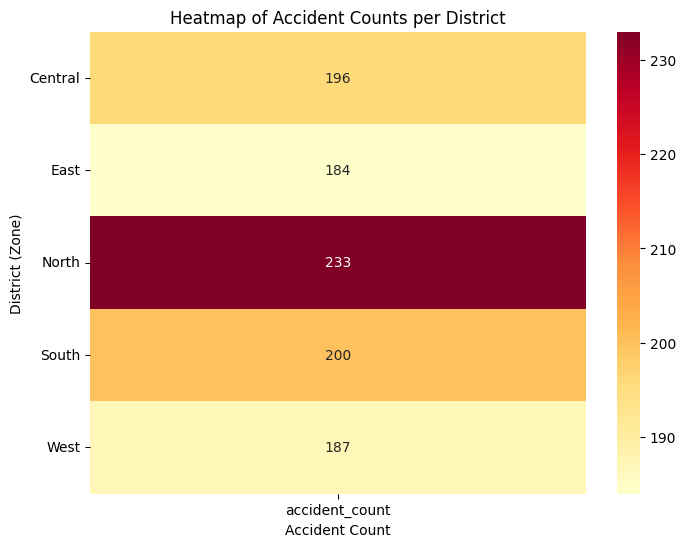

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of accidents per district ('zone')
district_counts = df['zone'].value_counts().reset_index()
district_counts.columns = ['zone', 'accident_count']

# Pivot the data to create a matrix for the heatmap
# We need a dummy column to create a pivot table with one column
district_counts['dummy'] = 1
heatmap_data = district_counts.pivot_table(index='zone', values='accident_count', aggfunc='sum')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Heatmap of Accident Counts per District')
plt.xlabel('Accident Count')
plt.ylabel('District (Zone)')
plt.yticks(rotation=0)
plt.show()

In [ ]:
display(df.columns)

Index(['lat', 'lon', 'vehicle_type', 'cause', 'severity', 'timestamp',
       'traffic_volume', 'vehicle_speed', 'traffic_density', 'zone',
       'intersection', 'report_text', 'date', 'count', 'cluster'],
      dtype='object')

In [ ]:
import plotly.express as px

# Convert 'timestamp' to datetime and extract date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

# Group by date and count accidents
accidents_over_time = df.groupby('date').size().reset_index(name='accident_count')

# Convert date back to datetime for plotly
accidents_over_time['date'] = pd.to_datetime(accidents_over_time['date'])

# Create animated line plot
fig = px.line(accidents_over_time, x='date', y='accident_count', title='Accidents Over Time (Animated)')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of Accidents',
    hovermode='x unified'
)
fig.show()

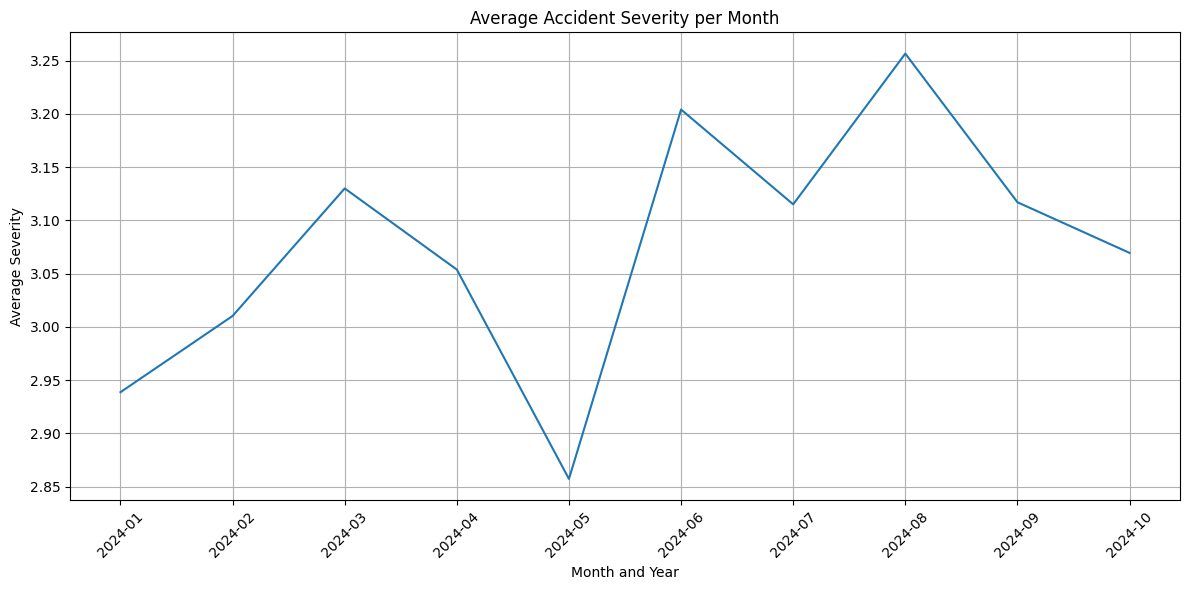

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract year and month
df['year_month'] = df['timestamp'].dt.to_period('M')

# Group by month and calculate the average severity
monthly_avg_severity = df.groupby('year_month')['severity'].mean().reset_index()
monthly_avg_severity['year_month'] = monthly_avg_severity['year_month'].astype(str)


# Create time series line plot of average severity
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_severity, x='year_month', y='severity')
plt.title('Average Accident Severity per Month')
plt.xlabel('Month and Year')
plt.ylabel('Average Severity')
plt.xticks(rotation=45)
plt.grid(True) # Add grid here
plt.tight_layout()
plt.show()

/tmp/ipython-input-3619749850.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




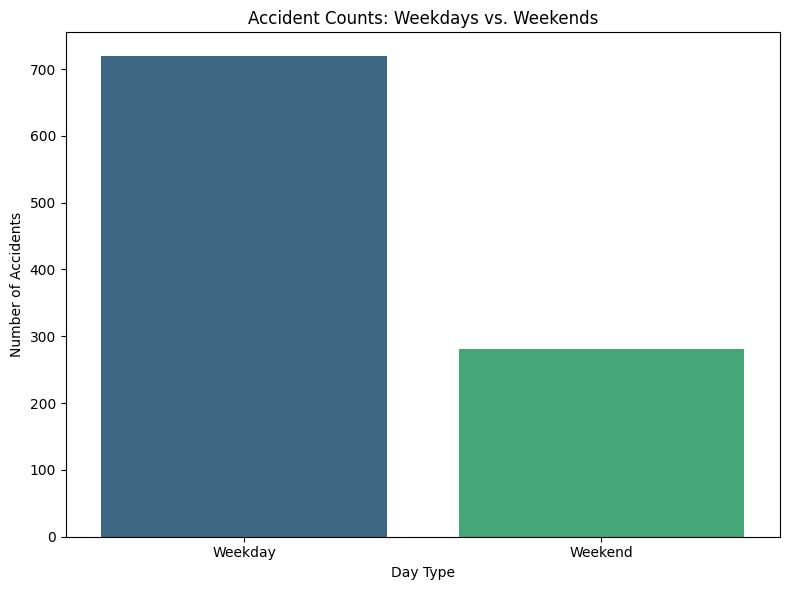

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract the day of the week
df['day_of_week'] = df['timestamp'].dt.day_name()

# Categorize as weekday or weekend
weekday_weekend_map = {
    'Monday': 'Weekday',
    'Tuesday': 'Weekday',
    'Wednesday': 'Weekday',
    'Thursday': 'Weekday',
    'Friday': 'Weekday',
    'Saturday': 'Weekend',
    'Sunday': 'Weekend'
}
df['day_type'] = df['day_of_week'].map(weekday_weekend_map)

# Count accidents by day type
day_type_counts = df['day_type'].value_counts().reset_index()
day_type_counts.columns = ['day_type', 'accident_count']

# Create a bar plot to compare weekday vs. weekend accidents
plt.figure(figsize=(8, 6))
sns.barplot(data=day_type_counts, x='day_type', y='accident_count', palette='viridis')
plt.title('Accident Counts: Weekdays vs. Weekends')
plt.xlabel('Day Type')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

**Reasoning**:
The previous command failed because the preprocessed DataFrame `X` still contains string columns that were not properly handled by the `ColumnTransformer`'s 'remainder' strategy. Specifically, columns like 'report_text', 'date', 'count', 'cluster', 'year_month', and 'day_of_week' which were not explicitly included in the `numerical_features` or `categorical_features` lists were passed through as objects (strings in some cases) causing the error during model fitting. I need to explicitly drop these non-numeric columns from the feature matrix `X` before training the model.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge # Using Ridge regression as an example


# Define the feature matrix X (excluding the target variable 'severity' and non-numeric passthrough columns)
# Identify non-numeric columns in the preprocessed DataFrame
non_numeric_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Drop 'severity' (already done above, but good to be explicit) and the identified non-numeric columns
cols_to_drop = ['severity'] + non_numeric_cols
X = df_preprocessed_df.drop(cols_to_drop, axis=1)

# Define the target variable vector y using the 'severity' column from the original DataFrame
y = df['severity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the chosen regression model (Ridge)
model = Ridge()

# Fit the model to the training data
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


Sorted Coefficients by Absolute Value:


Feature  Coefficient  Abs_Coefficient
38   intersection_Junction_8     0.474355         0.474355
37   intersection_Junction_7    -0.473078         0.473078
29  intersection_Junction_18     0.469560         0.469560
34   intersection_Junction_4    -0.343313         0.343313
30  intersection_Junction_19     0.290225         0.290225
17                zone_North    -0.275934         0.275934
24  intersection_Junction_13     0.274098         0.274098
26  intersection_Junction_15     0.254342         0.254342
27  intersection_Junction_16    -0.243437         0.243437
25  intersection_Junction_14    -0.240521         0.240521
18                zone_South     0.201464         0.201464
22  intersection_Junction_11    -0.190335         0.190335
21  intersection_Junction_10     0.180576         0.180576
19                 zone_West     0.173217         0.173217
20   intersection_Junction_1    -0.165665         0.165665
28  intersection_Junction_17    -0.135664         0.135664
35   intersection_Junction_5    -0.130569         0.130569
12  cause_Mechanical Failure     0.122479         0.122479
9          cause_Bad Weather     0.118716         0.118716
14            cause_Speeding    -0.116515         0.116515
16                 zone_East    -0.113543         0.113543
31   intersection_Junction_2     0.102802         0.102802
23  intersection_Junction_12    -0.101684         0.101684
39   intersection_Junction_9    -0.083361         0.083361
13         cause_Signal Jump    -0.073861         0.073861
5           vehicle_type_Bus     0.070336         0.070336
32  intersection_Junction_20     0.063728         0.063728
40          day_type_Weekday     0.049429         0.049429
41          day_type_Weekend    -0.049429         0.049429
4          vehicle_type_Bike    -0.039267         0.039267
33   intersection_Junction_3    -0.037907         0.037907
0             traffic_volume     0.037351         0.037351
36   intersection_Junction_6     0.035846         0.035846
11       cause_Drunk Driving    -0.028777         0.028777
7    vehicle_type_Pedestrian     0.023509         0.023509
10          cause_Distracted    -0.022042         0.022042
8         vehicle_type_Truck    -0.020022         0.020022
3          vehicle_type_Auto    -0.017484         0.017484
2            traffic_density     0.017371         0.017371
6           vehicle_type_Car    -0.017071         0.017071
1              vehicle_speed    -0.016006         0.016006
15              zone_Central     0.014795         0.014795


Top 10 features selected for visualization:
['intersection_Junction_8', 'intersection_Junction_7', 'intersection_Junction_18', 'intersection_Junction_4', 'intersection_Junction_19', 'zone_North', 'intersection_Junction_13', 'intersection_Junction_15', 'intersection_Junction_16', 'intersection_Junction_14']

Top categorical features for plotting: ['intersection', 'zone']
Top numerical features for plotting: []


/tmp/ipython-input-3800341435.py:70: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




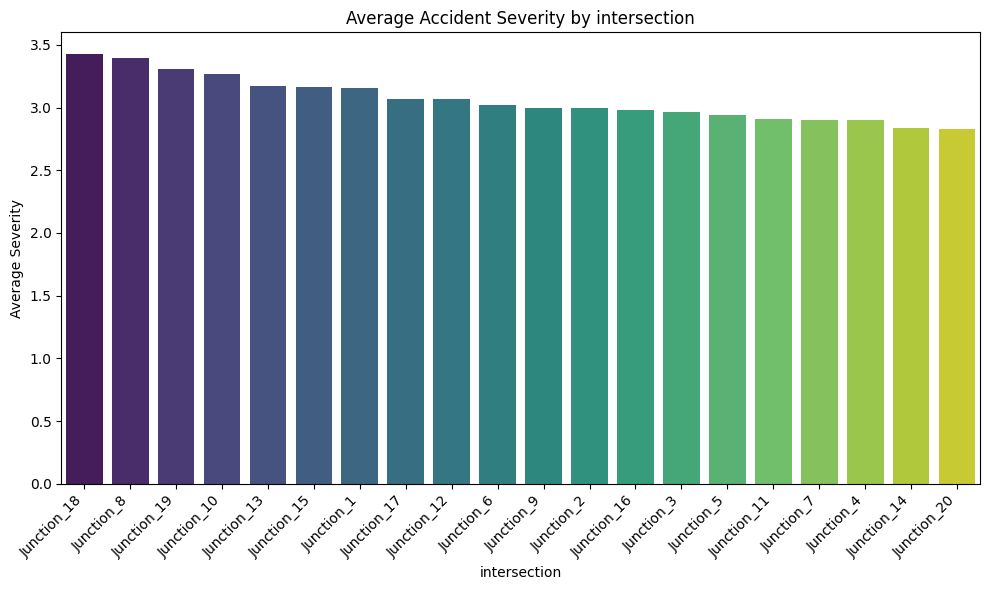

/tmp/ipython-input-3800341435.py:70: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




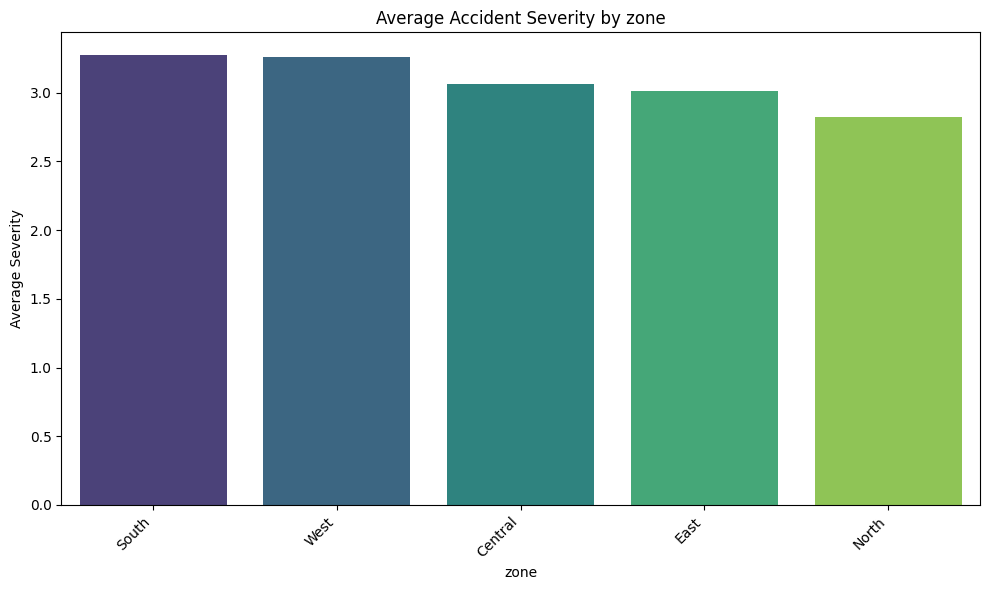

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the coefficients from the trained model
coefficients = model.coef_

# Get the feature names from the training data
feature_names = X_train.columns

# Create a DataFrame to store feature names and their coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Calculate the absolute value of coefficients for ranking
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])

# Sort features by the absolute value of their coefficients in descending order
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the sorted coefficients
print("Sorted Coefficients by Absolute Value:")
display(coef_df_sorted)

# 1. Select the top 10 features based on the sorted coefficients
top_features = coef_df_sorted.head(10)['Feature'].tolist()
print("\nTop 10 features selected for visualization:")
print(top_features)

# Identify which of these top features are categorical and which are numerical
# We need to refer back to the original feature lists before one-hot encoding
original_categorical_features = ['vehicle_type', 'cause', 'zone', 'intersection', 'day_type']
original_numerical_features = ['traffic_volume', 'vehicle_speed', 'traffic_density']

# Initialize lists for top categorical and numerical features
top_categorical_features = []
top_numerical_features = []

# Iterate through the top features and determine their original type
for feature in top_features:
    is_categorical = False
    # Check if the feature is a result of one-hot encoding of an original categorical feature
    for original_cat in original_categorical_features:
        if feature.startswith(original_cat + '_'):
            # Add the original categorical feature name if not already added
            if original_cat not in top_categorical_features:
                top_categorical_features.append(original_cat)
            is_categorical = True
            break # Move to the next top feature

    if not is_categorical:
        # Check if the feature is one of the original numerical features
        if feature in original_numerical_features:
            top_numerical_features.append(feature)
        # Note: 'lat' and 'lon' were numerical but excluded from the model features X.
        # If they were included and in the top features, they'd be handled here.
        # For this specific list of top features, all are from categorical or the 3 numerical features used.


print("\nTop categorical features for plotting:", top_categorical_features)
print("Top numerical features for plotting:", top_numerical_features)


# 2. Create plots for each selected feature against severity

# Plotting for Top Categorical Features
for cat_feature in top_categorical_features:
    plt.figure(figsize=(10, 6))
    # Calculate the average severity for each category
    avg_severity_by_cat = df.groupby(cat_feature)['severity'].mean().sort_values(ascending=False)
    sns.barplot(x=avg_severity_by_cat.index, y=avg_severity_by_cat.values, palette='viridis')
    plt.title(f'Average Accident Severity by {cat_feature}')
    plt.xlabel(cat_feature)
    plt.ylabel('Average Severity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plotting for Top Numerical Features
for num_feature in top_numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=num_feature, y='severity', alpha=0.6)
    plt.title(f'Accident Severity vs. {num_feature}')
    plt.xlabel(f'{num_feature} (Original Scale)') # Indicate original scale as scaling was applied for modeling
    plt.ylabel('Severity')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 1.3049029060196835
Mean Squared Error (MSE): 2.280346986961468
R-squared (R2): -0.1107524382720042
